#### Seminar #4. Exploratory data analysis

Goals/Agenda
- Exploratory data analysis for band gap and Li-ion conductivity datasets

- Data visualization

- Finding trends and correlations



In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mp_api.client import MPRester

plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams['font.family'] = "sans-serif"
plt.rcParams['font.size'] = 10

### Band gap dataset

In [3]:
data = pd.read_csv('data/mp_eg_data.csv')

In [4]:
# statistics for numerical columns
data.describe()

,eg,nelements
count,103217.000000,103217.000000
mean,0.790016,3.294370
std,1.365640,0.888434
min,0.000000,1.000000
25%,0.000000,3.000000
50%,0.000000,3.000000
75%,1.144800,4.000000
max,17.891400,8.000000


In [5]:
# what about median?
data.median(numeric_only = True)

eg           0.0
nelements    3.0
dtype: float64

We see that the median value for the band gap distribution is 0.0 eV. It means at least a half of the population are metals.

In [6]:
print('number of metals', (data.eg == 0).sum())
print('number of non-metals', (data.eg > 0).sum())

number of metals 59505
number of non-metals 43712


There are two large groups. By plotting the histogram we see that there is a huge peak at x = 0.0 corresponding to the metals group. So, it's better to analyse each group separately.

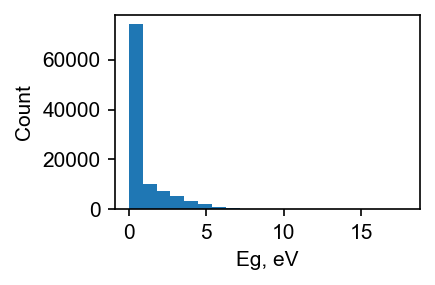

In [7]:
fig, ax = plt.subplots(dpi = 150, figsize = (3, 2))
_ = ax.hist(data.eg, bins = 20)

ax.set_xlabel('Eg, eV')
ax.set_ylabel('Count')
#ax.set_yscale('log')
plt.tight_layout()



In [8]:
metals = data[data.eg == 0.0]
nonmetals = data[data.eg > 0.0]

In [9]:
nonmetals.describe()

,eg,nelements
count,43712.000000,43712.000000
mean,1.865462,3.623696
std,1.548406,0.837801
min,0.000100,1.000000
25%,0.606900,3.000000
50%,1.500700,4.000000
75%,2.798300,4.000000
max,17.891400,8.000000


In [10]:
nonmetals.aggregate(
                {
                "eg": ["min", "max", "median", "skew", "std"]
                }
)

,eg
min,0.000100
max,17.891400
median,1.500700
skew,1.084769
std,1.548406


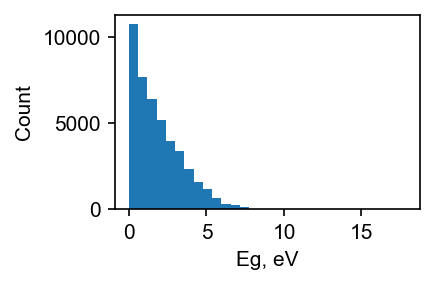

In [11]:
fig, ax = plt.subplots(dpi = 150, figsize = (3, 2))
_ = ax.hist(nonmetals.eg, bins = 30)

ax.set_xlabel('Eg, eV')
ax.set_ylabel('Count')
#ax.set_yscale('log')
plt.tight_layout()

Although the distribution is still very asymmetric, the descriptive statistics for the non-metal group (mean, median) is significantly different from the original dataset.

Let's check if oxygen containing structures has 0 band gap

In [12]:
def has_oxygen(chemsys):
    if 'O' in chemsys.split('-'):
        return True
    else:
        return False
    


In [13]:
metals['has_oxygen'] = metals['chemsys'].apply(has_oxygen).values

/var/folders/q1/b0tc24w948n0b0jq5_bn98000000gn/T/ipykernel_74230/2255053184.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metals['has_oxygen'] = metals['chemsys'].apply(has_oxygen).values


In [14]:
metals[metals.has_oxygen == True]

,eg,chemsys,nelements,formula,has_oxygen
128,0.0,Ac-Cu-F-O,4,AcCuO2F,True
129,0.0,Ac-Cu-O,3,AcCuO3,True
167,0.0,Ac-Mg-O,3,AcMgO3,True
170,0.0,Ac-Mn-O,3,AcMnO3,True
176,0.0,Ac-Ni-O,3,AcNiO3,True
...,...,...,...,...,...
103138,0.0,Cu-H-O-S-Zn,5,Zn3Cu2H14(SO9)2,True
103141,0.0,Cu-O-P-Zn,4,Zn3CuP2O9,True
103142,0.0,Co-Fe-O-Zn,4,Zn3Fe12(CoO12)2,True
103143,0.0,Fe-O-Zn,3,Zn3Fe2O7,True


As you can see, there are a lot of oxygen-containing structures with a zero gap. Is that OK? No, we know that oxygen-containing materials in general have a non-metallic behaviour. The reason for this observation is that the given dataset is calculated using the PBE xc functional, which underestimates a band gap. In reality, most of these systems are non-metallic. 

That's it for metals. It's more interesting to try to find the correlations between the band gap value and the chemical composition of non-metals.

In [15]:
nonmetals.groupby('formula').mean() # there are 27403 unique chemical compositions

,eg,nelements
formula,,
Ac2Br2O,0.2006,3.0
Ac2Cl2O,0.2363,3.0
Ac2MgGa,0.2016,3.0
Ac2MgTl,0.2200,3.0
Ac2O3,3.5226,2.0
...,...,...
ZrTlCuSe3,0.2271,4.0
ZrTlF5,4.8808,3.0
ZrVF6,2.4073,3.0


In [16]:
nonmetals.groupby('chemsys').mean() # there are 17387 unique chemical compositions

,eg,nelements
chemsys,,
Ac-Ag-Te,0.079400,3.0
Ac-Al-O,4.102400,3.0
Ac-B-O,0.807100,3.0
Ac-Br,4.103300,2.0
Ac-Br-O,2.220800,3.0
...,...,...
Te-Tl-Y,0.726600,3.0
Te-W,0.869140,2.0
Te-Zn,0.771620,2.0


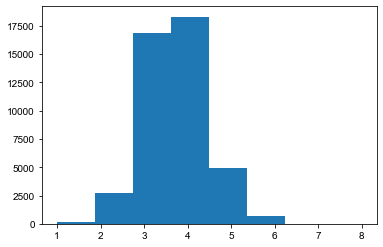

In [17]:
# distribution of the number of chemical elements in a structure
_ = plt.hist(nonmetals.nelements, bins = max(nonmetals.nelements))

Let's create more data

In [18]:
from pymatgen.core import Composition
def _electrons_per_atom(formula):
    comp = Composition(formula)
    return comp.total_electrons / comp.num_atoms
    


def _average_electroneg(formula):
    try:
        comp = Composition(formula)

        return comp.average_electroneg
    except: 
        return None




def _contains_halogen(formula):
    comp = Composition(formula)
    return comp.contains_element_type('halogen')


In [19]:
nonmetals['elneg_mean'] = nonmetals['formula'].apply(_average_electroneg)
nonmetals = nonmetals.dropna()
nonmetals['has_halogen'] = nonmetals['formula'].apply(_contains_halogen)
nonmetals['electrons_per_atom'] = nonmetals['formula'].apply(_electrons_per_atom)
# below is warnings that pymatgen is not able to
# append electronegativity for Ar, He, and Ne, and instead set it to Nan. 
# It would be great to remove this elements from the dataset.
# This can be called dataset cleansing

/Users/artemdembitskiy/opt/anaconda3/lib/python3.8/site-packages/pymatgen/core/periodic_table.py:221: UserWarning: No Pauling electronegativity for Ar. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/Users/artemdembitskiy/opt/anaconda3/lib/python3.8/site-packages/pymatgen/core/periodic_table.py:221: UserWarning: No Pauling electronegativity for He. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/Users/artemdembitskiy/opt/anaconda3/lib/python3.8/site-packages/pymatgen/core/periodic_table.py:221: UserWarning: No Pauling electronegativity for Ne. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/var/folders/q1/b0tc24w948n0b0jq5_bn98000000gn/T/ipykernel_74230/252248682.py:1: SettingWithCopyWarning: 
A value is trying to be set on

In [20]:
nonmetals.groupby('has_halogen').mean()

,eg,nelements,elneg_mean,electrons_per_atom
has_halogen,,,,
False,1.698330,3.648030,2.532132,18.607942
True,2.399461,3.546685,2.820922,19.405383


In [21]:
nonmetals.groupby('has_halogen').std()

,eg,nelements,elneg_mean,electrons_per_atom
has_halogen,,,,
False,1.399708,0.845607,0.332317,10.101855
True,1.824771,0.804404,0.382382,10.664142


In average, structures that contain halogen element have a wider bandgap

Let's check if Eg correlates with number of electrons per atom and the average electronegativity

-0.1844108993409914
0.1716243188502978


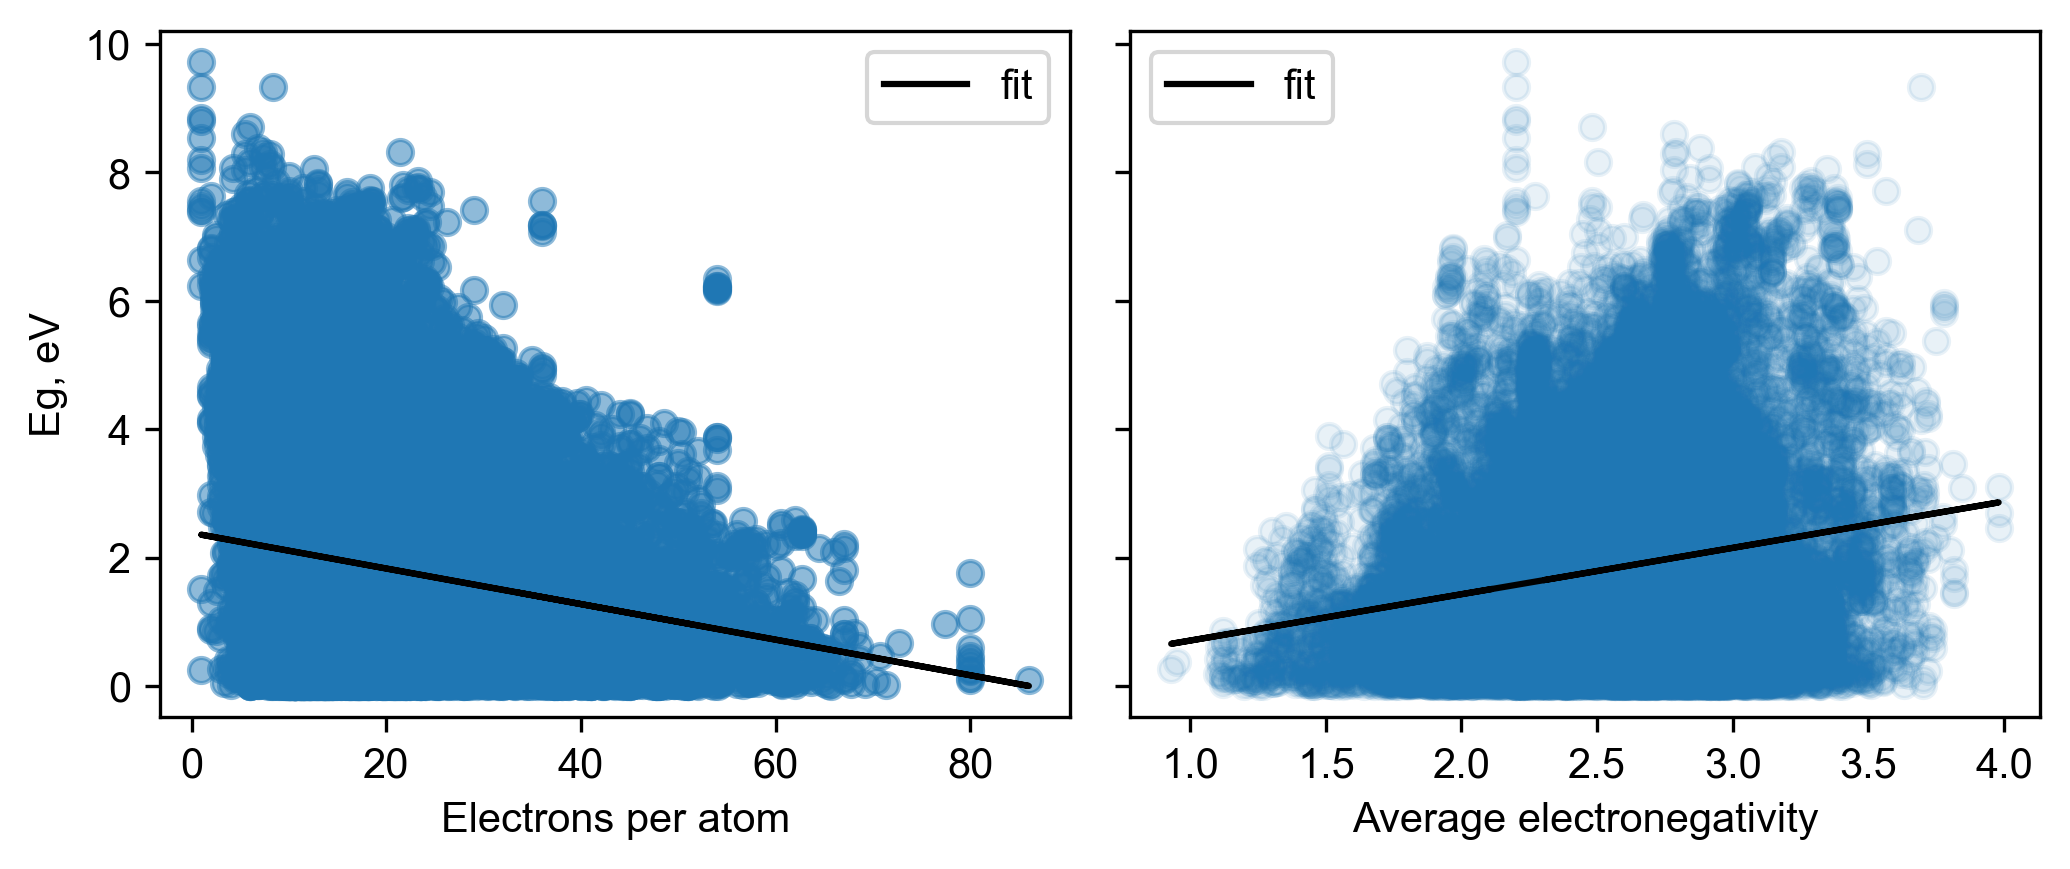

In [22]:
from scipy.stats import linregress

fig, (ax1, ax2) = plt.subplots(dpi = 300, ncols = 2, figsize = (7, 3), sharey = True)

x = nonmetals.electrons_per_atom
y = nonmetals.eg

ax1.scatter(x, y, alpha = 0.5)
ax1.set_xlabel('Electrons per atom')
ax1.set_ylabel('Eg, eV')
res = linregress(x, y)
print(res.rvalue)

ax1.plot(x, res.slope * x + res.intercept, color = 'k', label = 'fit')



x = nonmetals.elneg_mean


ax2.scatter(x, nonmetals.eg, alpha = 0.1,)
res = linregress(nonmetals.elneg_mean,nonmetals.eg)
print(res.rvalue)
ax2.plot(x, res.slope * x + res.intercept, color = 'k', label = 'fit')
ax2.set_xlabel('Average electronegativity')
ax1.legend()
ax2.legend()

plt.tight_layout()

The correlation is weak.

However, there are many chemical compositions (i.e. too many groups). Let's assign a chemical family to each chemical system so that we have a smaller number of groups to work with.

In [23]:
def set_family(chemsys):

    """
    not the best one aggregation
    you can play with it
    """
    elements = chemsys.split('-')

        
    if 'O' in elements:
        if ('S' in elements)&('P' not in elements):
            return 'sulfate'
        elif ('P' in elements)&('S' not in elements):
            return 'phosphate'
        elif ('Si' in elements)&('P' not in elements):
            return 'silicate'
        else:
            return 'oxide'
        
        
        
    if 'F' in elements:
        return 'fluoride'

    if 'S' in elements:
        return 'sulfide'

    if 'P' in elements:
        return 'phosphide'
    
    if 'Cl' in elements:
        return 'chloride'
    
    if 'I' in elements:
        return 'iodide'
    
    if 'Br' in elements:
        return 'bromide'
        
    else:
        return 'other'


In [24]:
nonmetals['family'] = nonmetals['chemsys'].apply(set_family)


Let's count number of samples in each family

In [25]:
nonmetals.groupby('family').count()

,eg,chemsys,nelements,formula,elneg_mean,has_halogen,electrons_per_atom
family,,,,,,,
bromide,565,565,565,565,565,565,565
chloride,1221,1221,1221,1221,1221,1221,1221
fluoride,3189,3189,3189,3189,3189,3189,3189
iodide,436,436,436,436,436,436,436
other,4183,4183,4183,4183,4183,4183,4183
oxide,24932,24932,24932,24932,24932,24932,24932
phosphate,3795,3795,3795,3795,3795,3795,3795
phosphide,366,366,366,366,366,366,366
silicate,1678,1678,1678,1678,1678,1678,1678


In [26]:
groups = nonmetals.groupby('family').mean().reset_index()
groups['eg_std']  = nonmetals.groupby('family').std().reset_index()['eg']
groups = groups.sort_values(by = 'eg')
x = groups.family
y = groups.eg
#y_err = groups.eg_std


Text(0.5, 0, 'Eg, eV')

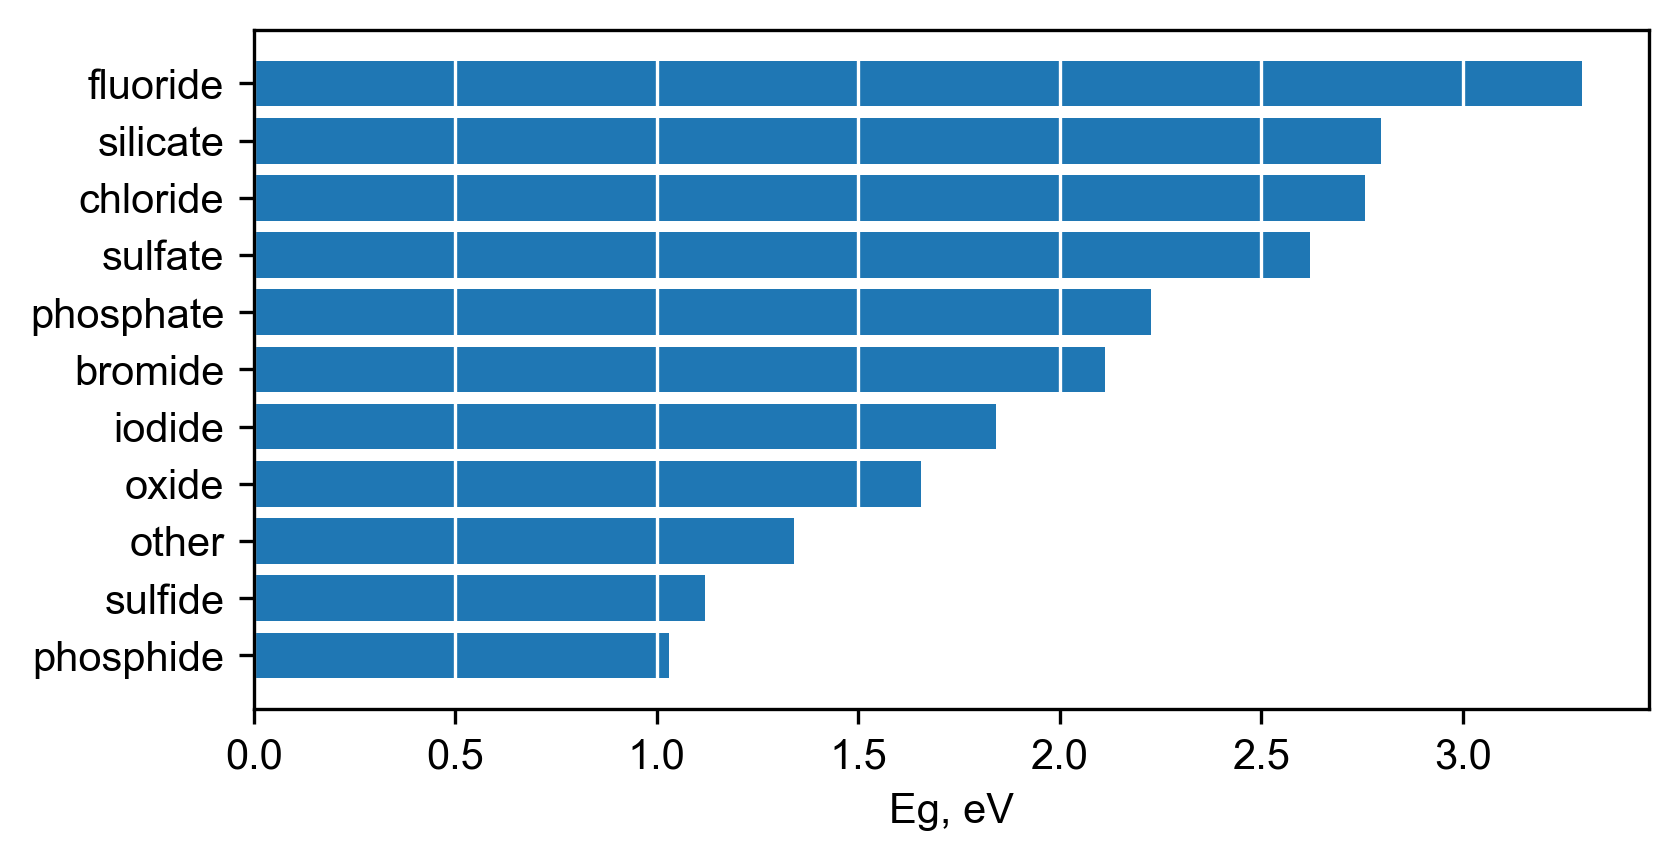

In [27]:
fig, ax = plt.subplots(dpi = 300, figsize = (6, 3))
ax.barh(x, y)
ax.xaxis.grid(True, color = 'w')
ax.set_xlabel('Eg, eV')


In average, fluoride materials have a wider band gap, while phoshides have the lowest band gap among the groups. However, the deviation of the band gap in each of the groups from the mean value of each of the groups is high.

Text(0, 0.5, 'Eg, eV')

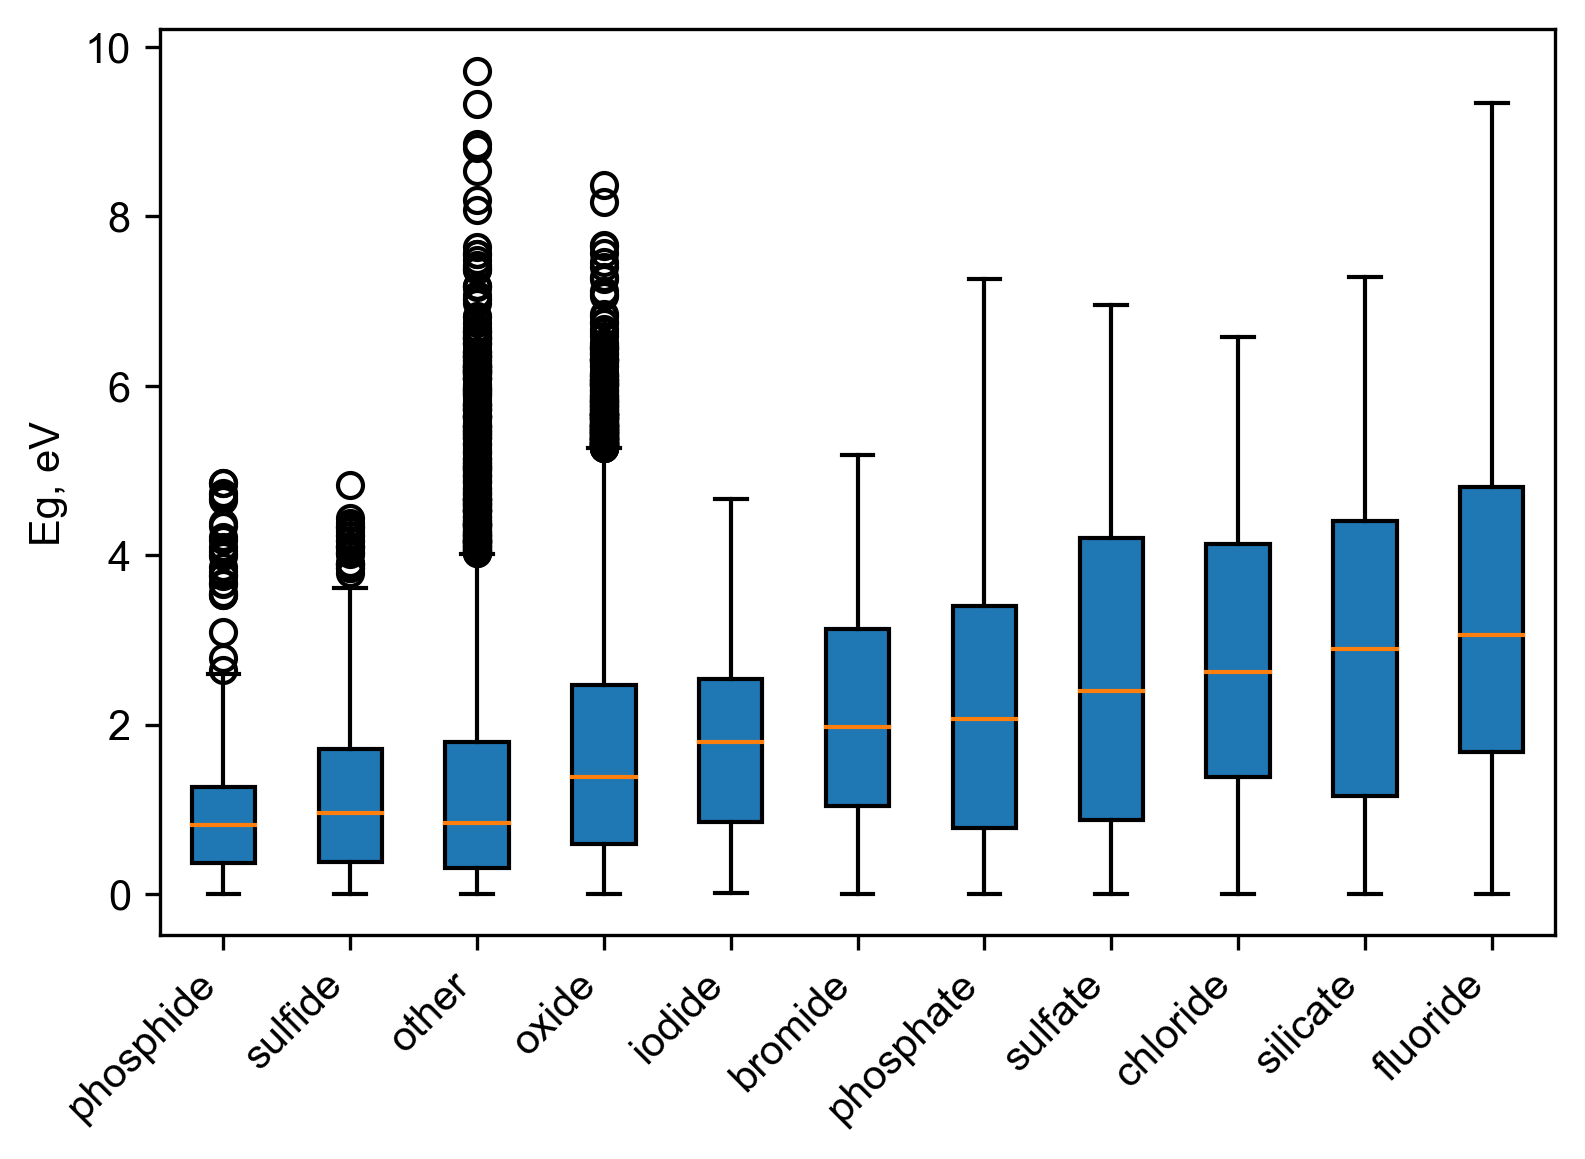

In [29]:
fig, ax = plt.subplots(dpi = 300)

families = groups.family
bplot = ax.boxplot(
[nonmetals[nonmetals.family == family].eg for family in families
],
                   patch_artist=True,  # fill with color

                   labels = families
                   )  # will 

_ = ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45, ha='right')

ax.set_ylabel('Eg, eV')
#fig.savefig('figures/eg_family_barplot.png')



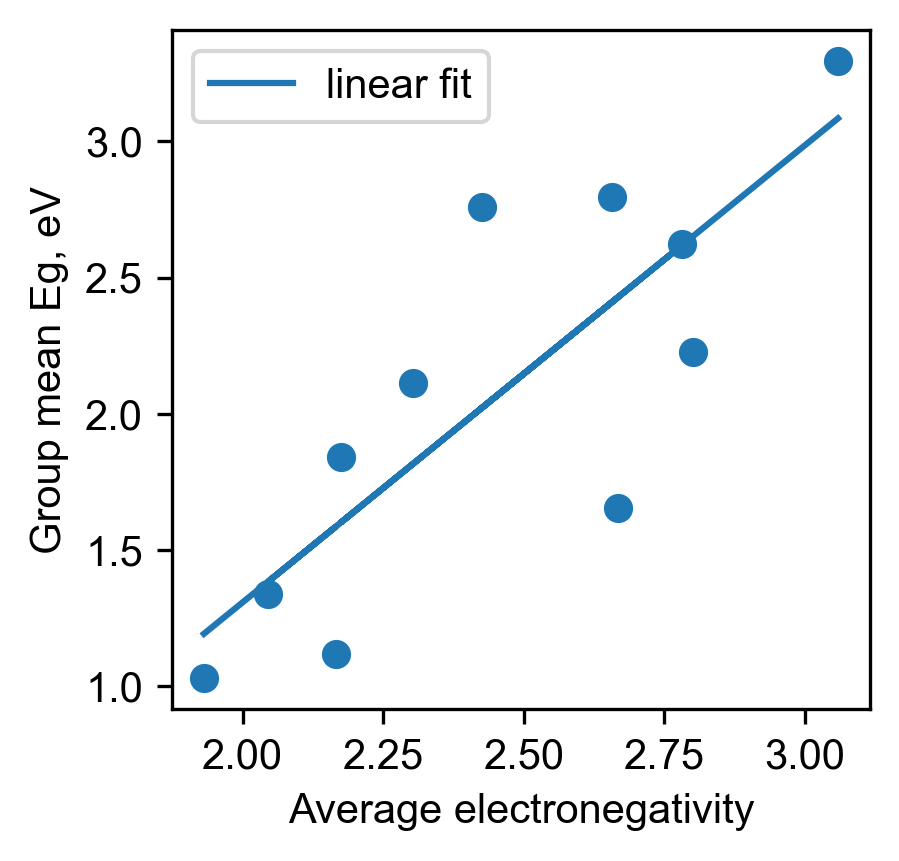

In [30]:
fig, ax = plt.subplots(dpi = 300, figsize  = (3, 3))

x = groups.elneg_mean
y = groups.eg
ax.scatter(x, y)
res = linregress(x, y)
res

ax.plot(x, res.slope * x + res.intercept, label = 'linear fit')
ax.set_xlabel('Average electronegativity')
ax.set_ylabel('Group mean Eg, eV')
ax.legend()


In [35]:
# Pearson correlation coefficient
print('Rp:', res.rvalue.round(2)) 

Rp: 0.81


Now we see that there is a strong correlation between the average Eg of a group and the average electronegativity.

#### Task 1

Study the correlation between the bandgap and average electronegativity in binary nonmetallic compounds (nelements == 2). Consider only halides and oxides for this study.
- plot Eg distribution for binary compounds
- plot Eg vs. Average electronegativity

- report correlation coefficient

### Task 2: Li-ion conductors dataset

The dataset contains Li ion conductivities measured for Li-based ceramics.

Dataset source: https://pcwww.liv.ac.uk/~msd30/lmds/LiIonDatabase.html

Note: We modified the dataset. It is poisoned. You should clean it.

- read data/LiIonDatabase_poisoned.csv
- drop nan values

- remove outliers and unrealistic values (Note: use pandas quantile method)
- drop useless columns
- drop data measured at T > 30
- report descriptive statistics for the target column

- plot the distribution for a target column
- add log_target column
- plot and describe the log_target distribution
- perform aggregation by Family and ChemicalFamily columns
- plot a barplot for the mean ionic conductivity (log_target) of each group.
- do you see any trends?

In [749]:
# read data

df = pd.read_csv('data/LiIonDatabase_poisoned.csv')